# 2022-07-23 • Record many neurons

## Imports

In [6]:
#

In [7]:
using Revise

In [8]:
using MyToolbox

In [9]:
using VoltoMapSim

## Params

Based on Roxin; same as previous nb's.

In [10]:
d = 6
p = get_params(
    duration = 10minutes,
    #duration = 10seconds,
    p_conn = 0.04,
    g_EE = 1   / d,
    g_EI = 18  / d,
    g_IE = 36  / d,
    g_II = 31  / d,
    ext_current = Normal(-0.5 * pA/√seconds, 5 * pA/√seconds),
    E_inh = -80 * mV,
    record_v = [1:40; 801:810;],
);

## Run sim

In [11]:
s = cached(sim, [p.sim]);

Takes ~11' on work pc.

In [12]:
s = augment_simdata(s, p);

## Eval conntest perf for all v recorded

In [13]:
recorded = p.sim.network.record_v;

In [14]:
# using Base.Threads

In [15]:
detrates = Dict()

# @threads for m in recorded
for m in recorded
    ii = get_input_info(m, s, p);
    perf = cached(evaluate_conntest_perf, [ii.v, ii.spiketrains, p], key=[p, m])
    detrates[m] = perf.detection_rates
end;

Connection tests take ~1:20 per neuron.
So for 50 neurons → 66'.

Testing can happen multithreaded. So we'll set the JULIA_NUM_THREADS env var (to one less than the num logical cores).

Ah seems you can use all cores, as it doesn't utilize fully, so there's left for you.

With the threading it was sometimes up to 7:30 per neuron..

## Plot distributions

In [16]:
using PyPlot

In [17]:
using VoltoMapSim.Plot

In [23]:
exc_rec = [1:40;]
inh_rec = [801:810;];

In [192]:
function ydistplot(pairs...; setkw...)
    labels = [p[1] for p in pairs]
    datas = [p[2] for p in pairs]
    fig, ax = plt.subplots()
    for (x, ys) in enumerate(datas)
        xs = x .- 0.15 .+ 0.1*rand(length(ys))
        ax.plot(xs, ys, "k.", clip_on=false, alpha=0.4)
        ax.boxplot(
            ys, whis=(5,95), positions=[x+0.1], showfliers=false, showmeans=true,
            medianprops=Dict(:color=>"black"),
            meanprops=Dict(:marker=>"D", :ms=>3, :mfc=>"black", :mec=>"none")
        )
    end
    N = length(labels)
    set(ax; xtype=:categorical, xlim=[0.5, N+0.5], setkw...)
    ax.set_xticks(1:N)  # can't use `set` as that sets xticks
    ax.set_xticklabels(labels)
    return ax
end;

In [193]:
function detplot(coll, name)
    N = length(coll)
    ax = ydistplot(
        "Exc. inputs" => [detrates[n].TPR_exc for n in coll],
        "Inh. inputs" => [detrates[n].TPR_inh for n in coll],
        "Unconn." => [detrates[n].FPR for n in coll],
        ylim = [0,1],
        hylabel = "Detection rates for $(name) neurons (n = $N)",
    )
    add_α_line(ax, p.evaluation.α)
    return nothing
end;

In [ ]:
detplot(exc_rec, "excitatory")

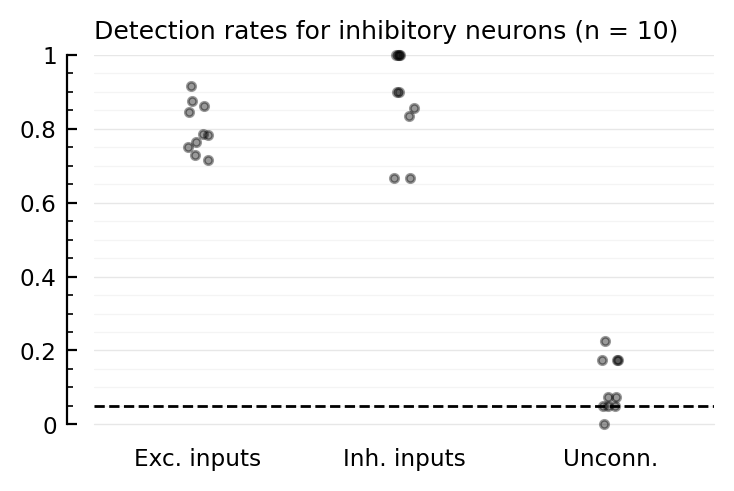

In [150]:
detplot(inh_rec, "inhibitory")

In [ ]:
plt.boxplot()